### Treść zadania

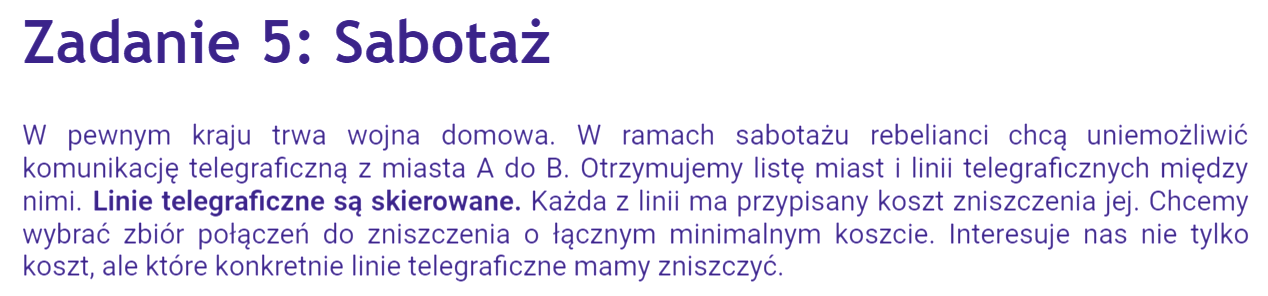

### Omówienie algorytmu

Krótkie podsumowanie, co należy zrobić w zadaniu: $ max\_flow = min\_cut $. <br>
Warto zauważyć, że usunięcie krawędzi musi rozspójnić graf. Napiszemy więc algorytm podobny do tego, który był omawiany na ćwiczeniach <a href="../../../Ćwiczenia/11. Ćwiczenia/Zadania/[max-flow] Zadanie 2. (Spójność krawędziowa).ipynb">TUTAJ</a>. <br>
Tym razem jednak problem nie polega na usunięciu minimalnej liczby krawędzi, ale na usunięciu takich krawędzi, że ich sumaryczna waga jest najmniejsza i ich usunięcie rozspójnia graf. Jeżeli przypomnimy sobie definicję minimalnego przekroju w grafie ważonym, wszystko stanie się jasne. Przypomnienie podlinkowałem niżej:
###### Poniżej dokładne wyjaśnienie, czym jest min-cut
https://youtu.be/oHy3ddI9X3o?t=1062

<br>
Zatem algorytm będzie polegał na zbudowaniu grafu skierowanego, który przedstawia połączenia linii telegraficznych, a następnie znalezieniu w nim maksymalnego przepływu, najlepiej, przy pomocy algorytmu Edmondsa-Karpa, bo jest szybszy od Forda-Fulkersona (a algorytmów szybszych nie omawialiśmy, więc ich nie można za bardzo wykorzystywać). Mamy więc załatwioną pierwszą część zadania, czyli znalezienie kosztu krawędzi, które usuniemy. Pozostała nam jeszcze druga część zadania, która jest znacznie trudniejsza i polega na znalezieniu konkrentych krawędzi, które należy zniszczyć. To zostało omówione pod koniec zamieszczonego niżej nagrania z BIT Algo. Musimy zdać sobie sprawę, że krawędzie z minimalnego przekroju to są takie krawędzie które najbardziej ograniczają nam maksymalny przepływ, a mianowicie suma wag tych krawędzi jest równa wartości maksymalnego przepływu. W takiej sytuacji wiemy, że krawędzie, które odpowiadają minimalnemu przecięciu, będą w całkowicie wypełnione (ich pozostała pojemność wynosi 0). Z tego powodu, chcąc znaleźć krawędzie do usunięcia, musimy przejść od źródła przez wszystkie krawędzie, aż natrafimy na takie, których pozostała pojemność wynosi 0. Wówczas dodajemy krawędź do listy krawędzi do usunięcia i już dalej nie przechodzimy przez tę krawędź. Postępujemy tak aż znajdziemy wszystkie krawędzie o pozostałej przepustowości równej 0 i nie możemy już dalej się poruszać ze źródła (odwiedziliśmy całą część grafu, dochodząc do krawędzi, które nam blokują dalsze przejście).

### Złożoność

Zależy od użytego algorytmu, który znajduje maksymalny przepływ. Ja korzystam z algorytmu Edmondsa-Karpa.
###### Obliczeniowa:
$ O(VE^2) $
###### Pamięciowa:
$ O(V^2) $

### Implementacja #1
##### (Dla grafów skierowanych - wszystkie krawędzie muszą być skierowane)

In [86]:
from queue import Queue


def add_back_edges(G):
    n = len(G)
    counts = [0] * n  # Numbers of edges in an initial graph (before modification)
    
    for u in range(n):
        counts[u] = len(G[u])
        
    for u in range(n):
        for i in range(counts[u]):
            v, _ = G[u][i]
            G[v].append((u, 0))  # Add an edge with no weight
            
    return counts
    
    
def remove_back_edges(G, counts):
    n = len(G)
    
    for u in range(n):
        while len(G[u]) > counts[u]:
            G[u].pop()


def update_flow(flow, parents, bottleneck, t):
    u = t
    
    while parents[u] is not None:
        v = parents[u]
        flow[v][u] += bottleneck
        flow[u][v] -= bottleneck
        u = v


def edmonds_karp(G: 'graph represented by adjacency lists', s: 'source vertex', t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    flow     = [[0] * n for _ in range(n)]
    parents  = [None] * n
    visited  = [0] * n
    token    = 1  # Number of iteration to check which vertices have been visited
    max_flow = 0
    
    counts = add_back_edges(G)
    
    while True:
        bottleneck = inf
        q = Queue()
        q.put((s, bottleneck))
        visited[s] = token
        found_path = False
        
        while not q.empty():
            u, bottleneck = q.get()
            
            if u == t:
                update_flow(flow, parents, bottleneck, t)
                found_path = True
                break
            
            for v, capacity in G[u]:
                remaining = capacity - flow[u][v]
                if visited[v] != token and remaining > 0:
                    visited[v] = token
                    parents[v] = u
                    q.put((v, min(remaining, bottleneck)))
        
        if not found_path: break
        max_flow += bottleneck
        token += 1
        
    remove_back_edges(G, counts)
        
    return max_flow, flow


def directed_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
    return G


def find_lines_to_remove(G, flow, s):
    n = len(G)
    visited = [False] * n
    lines = []
    
    def dfs(u):
        visited[u] = True
        for v, capacity in G[u]:
            if visited[v]: continue
            if capacity > flow[u][v]:
                dfs(v)
            elif capacity == flow[u][v]:
                lines.append((u, v))   
                
    dfs(s)
    return lines


def blow_up_lines(L: 'lines array', s: 'begin city', t: 'end city'):
    G = directed_weighted_graph_list(L)
    cost, flow = edmonds_karp(G, s, t)
    # Find lines to remove
    lines = find_lines_to_remove(G, flow, s)
    return cost, lines

###### Kilka testów

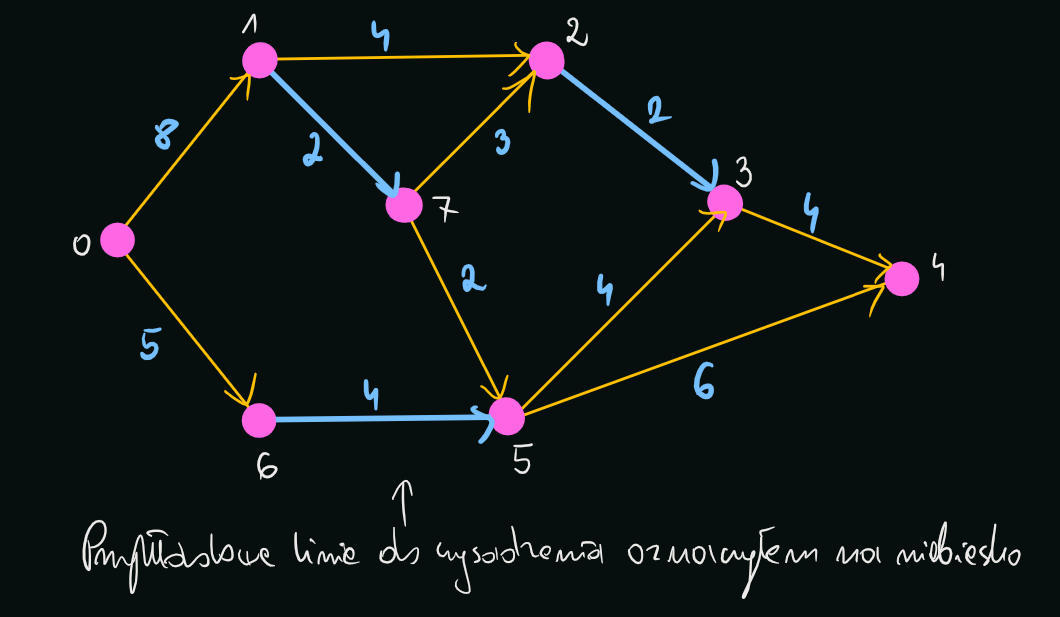

In [87]:
E = [(0, 1, 8), (0, 6, 5), (1, 2, 4), (1, 7, 2), (7, 2, 3), (6, 5, 4), (7, 5, 2), (2, 3, 2), 
     (5, 3, 4), (5, 4, 6), (3, 4, 4)]
A = 0
B = 4

print(blow_up_lines(E, A, B))

(8, [(2, 3), (1, 7), (6, 5)])


In [88]:
# Teraz przykład dla nieco innych miast
A = 7
B = 4

print(blow_up_lines(E, A, B))

(4, [(2, 3), (7, 5)])


In [89]:
A = 5
B = 6

print(blow_up_lines(E, A, B))

(0, [])


### Implementacja #2 (gorsza wersja dla grafów nieskierowanych)
##### (Dla grafów, w których występują krawędzie zwrócone w dwie strony (o tych samych wagach lub różnych) (algorytm ten działa też dla grafów skierowanych))

Pierwotnie w zadaniu linie telegraficzne były nieskierowane, ale treść została zmieniona dla ułatwienia. Ja jednak zaimplementowałem również tę wersję "trudniejszą".
###### UWAGA
W poniższej implementacji na wejściu możemy również dostać graf skierowany i to nam nic nie zmieni (algorytm zadziała prawidłowo).

In [77]:
from queue import Queue


def map_graph(G: 'graph represented by adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    w = n
        
    for u in range(n):
        for v, weight in G[u]:
            if u < v:
                G2.append([])
                G2[u].append((w, weight))
                G2[w].append((v, weight))
                w += 1
            else:
                G2[u].append((v, weight))
                    
    return G2


def add_back_edges(G):
    n = len(G)
    counts = [0] * n  # Numbers of edges in an initial graph (before modification)
    
    for u in range(n):
        counts[u] = len(G[u])
        
    for u in range(n):
        for i in range(counts[u]):
            v, _ = G[u][i]
            G[v].append((u, 0))  # Add an edge with no weight
            
    return counts
            
    
def remove_back_edges(G, counts):
    n = len(G)
    
    for u in range(n):
        while len(G[u]) > counts[u]:
            G[u].pop()

            
def update_flow(flow, parents, bottleneck, t):
    u = t
    
    while parents[u] is not None:
        v = parents[u]
        flow[v][u] += bottleneck
        flow[u][v] -= bottleneck
        u = v


def edmonds_karp(G: 'graph represented by adjacency lists', s: 'source vertex', t: 'target vertex'):
    n = len(G)
    inf = float('inf')
    flow     = [[0] * n for _ in range(n)]
    parents  = [None] * n
    visited  = [0] * n
    token    = 1  # Number of iteration to check which vertices have been visited
    max_flow = 0
    
    while True:
        bottleneck = inf
        q = Queue()
        q.put((s, bottleneck))
        visited[s] = token
        found_path = False
        
        while not q.empty():
            u, bottleneck = q.get()
            
            if u == t:
                update_flow(flow, parents, bottleneck, t)
                found_path = True
                break
            
            for v, capacity in G[u]:
                remaining = capacity - flow[u][v]
                if visited[v] != token and remaining > 0:
                    visited[v] = token
                    parents[v] = u
                    q.put((v, min(remaining, bottleneck)))
        
        if not found_path: break
        max_flow += bottleneck
        token += 1
        
    return max_flow, flow


def find_lines_to_remove(G, flow, s, m):
    n = len(G)
    visited = [False] * n
    lines = []
    
    def dfs(u):
        visited[u] = True
        for v, capacity in G[u]:
            if visited[v]: continue
            if capacity > flow[u][v]:
                dfs(v)
            elif capacity == flow[u][v]:
                # Check if the v vertex is a sentinel vertex
                # If it does so, take its only one neighbour
                # which will be the original vertex
                if v >= m: v = G[v][0][0]
                if visited[v]: continue
                lines.append((u, v))   
                
    dfs(s)
    return lines


def undirected_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
        G[e[1]].append((e[0], e[2]))
    return G


def blow_up_lines(L: 'lines array', s: 'begin city', t: 'end city'):
    G = undirected_weighted_graph_list(L)
    n = len(G)
    G2 = map_graph(G)
    counts = add_back_edges(G2)
    cost, flow = edmonds_karp(G2, s, t)
    remove_back_edges(G2, counts)
    # Find lines to remove
    lines = find_lines_to_remove(G2, flow, s, n)
    return cost, lines

###### Kilka testów

##### Dla grafu nieskierowanego

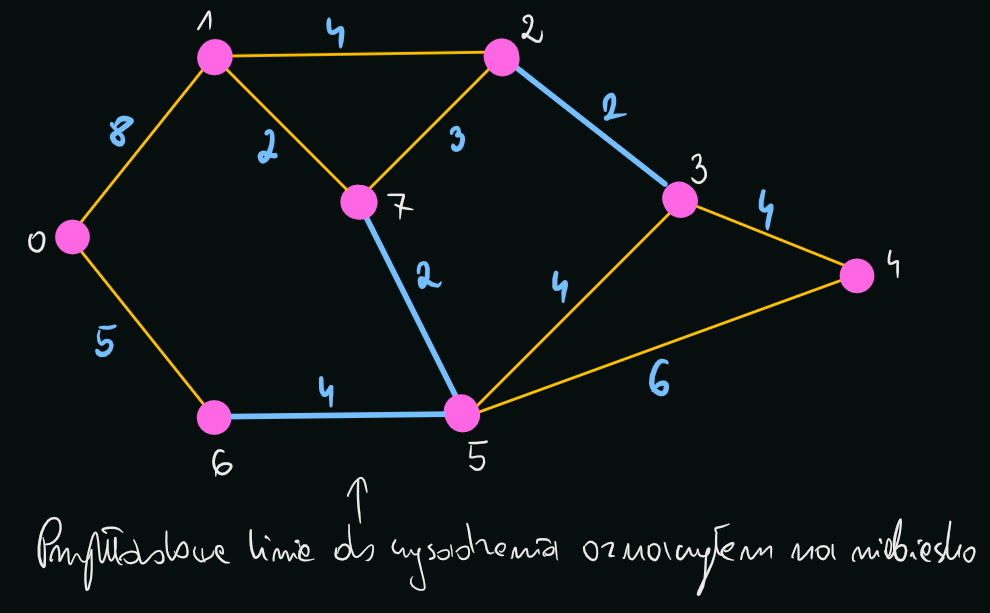

In [78]:
E = [(0, 1, 8), (0, 6, 5), (1, 2, 4), (1, 7, 2), (7, 2, 3), (6, 5, 4), (7, 5, 2), (2, 3, 2), 
     (5, 3, 4), (5, 4, 6), (3, 4, 4)]

A = 0
B = 4
blow_up_lines(E, A, B)

(8, [(7, 5), (2, 3), (6, 5)])

In [79]:
A = 7
B = 4
blow_up_lines(E, A, B)

(7, [(7, 1), (7, 2), (7, 5)])

In [80]:
A = 3
B = 4
blow_up_lines(E, A, B)

(10, [(3, 2), (3, 5), (3, 4)])

In [81]:
A = 5
B = 4
blow_up_lines(E, A, B)

(10, [(3, 4), (5, 4)])

##### Dla grafu skierowanego (działa prawidłowo, otrzymujemy te same rezultaty, co w Implementacji #1):

Musimy nadpisać końcową funkcję, aby tworzyła graf skierowany.

In [82]:
def blow_up_lines(L: 'lines array', s: 'begin city', t: 'end city'):
    G = directed_weighted_graph_list(L)
    cost, flow = edmonds_karp(G, s, t)
    # Find lines to remove
    lines = find_lines_to_remove(G, flow, s, len(G))
    return cost, lines

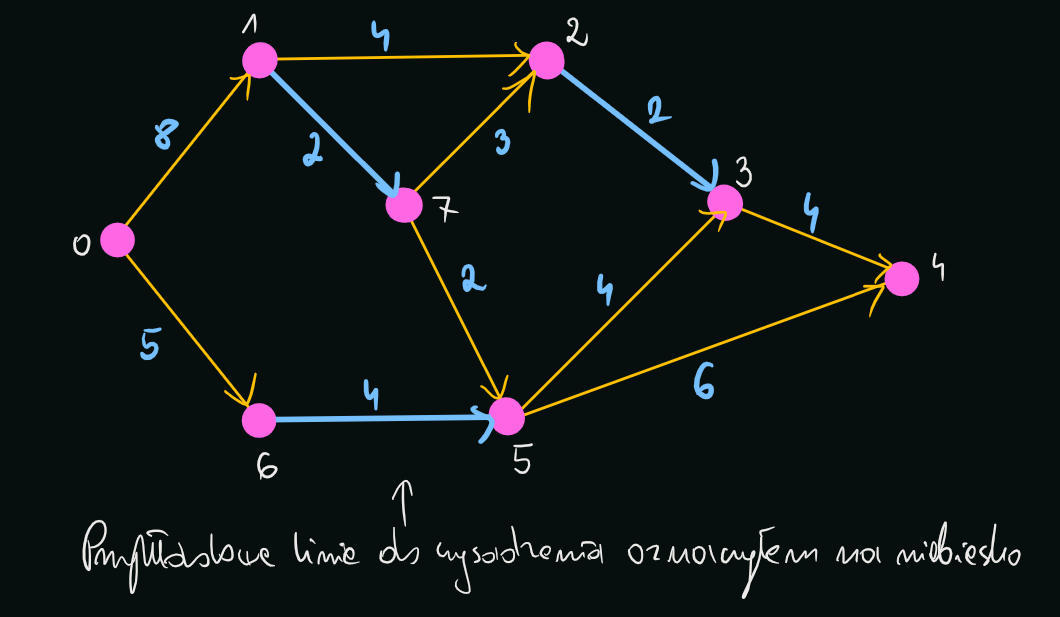

In [83]:
E = [(0, 1, 8), (0, 6, 5), (1, 2, 4), (1, 7, 2), (7, 2, 3), (6, 5, 4), (7, 5, 2), (2, 3, 2), 
     (5, 3, 4), (5, 4, 6), (3, 4, 4)]
A = 0
B = 4

print(blow_up_lines(E, A, B))

(8, [(2, 3), (1, 7), (6, 5)])


In [84]:
# Teraz przykład dla nieco innych miast
A = 7
B = 4

print(blow_up_lines(E, A, B))

(4, [(2, 3), (7, 5)])


In [85]:
A = 5
B = 6

print(blow_up_lines(E, A, B))

(0, [])


### Implementacja #3 (najlepsza wersja dla grafów nieskierowanych)
##### (Podobnie jak implementacja #2, również poniższy algorytm działa zarówno dla grafów nieskierowanych jak i dla skierowanych. Jest on jednak łatwiejszy w implementacji i nie wymaga dodawania sztucznych wierzchołków)

###### UWAGA
W poniższej implementacji na wejściu możemy również dostać graf skierowany i to nam nic nie zmieni (algorytm zadziała prawidłowo).

In [67]:
from queue import Queue


def bfs(G, s, t, parents, visited, token):
    n = len(G)
    q = Queue()
    q.put(s)
    visited[s] = token
    
    while not q.empty():
        u = q.get()
        for v in range(n):
            if not G[u][v] or visited[v] == token: continue
            q.put(v)
            visited[v] = token
            parents[v] = u
    
    return visited[t] == token


def get_bottleneck(G, s, t, parents):
    bottleneck = float('inf')
    u = t
    while u != s:
        bottleneck = min(bottleneck, G[parents[u]][u])
        u = parents[u]
    return bottleneck


def update_flow(G, s, t, parents, bottleneck):
    v = t
    while v != s:
        u = parents[v]
        G[u][v] -= bottleneck
        G[v][u] += bottleneck
        v = parents[v]

        
def create_residual_graph(G):
    n = len(G)
    G2 = [[0] * n for _ in range(n)]
    for u in range(n):
        for v, capacity in G[u]:
            G2[u][v] = capacity
    return G2
    

def edmonds_karp(G: 'graph represented by adjacency lists', s: 'source vertex', t: 'target vertex'):
    n = len(G)
    RG = create_residual_graph(G)  # We won't modify the input graph
    max_flow = 0
    parents = [-1] * n
    visited = [0] * n
    token = 1
    
    while bfs(RG, s, t, parents, visited, token):
        # Find an augmenting path and its bottleneck value
        bottleneck = get_bottleneck(RG, s, t, parents)
        # Update flow on a path which was found
        update_flow(RG, s, t, parents, bottleneck)
        # Increase a value of the maximum flow
        max_flow += bottleneck
        token += 1
            
    return max_flow, RG


def find_lines_to_remove(G, RG, s, m):
    n = len(G)
    visited = [False] * n
    lines = []
    
    def dfs(u):
        visited[u] = True
        for v, capacity in G[u]:
            if visited[v]: continue
            if RG[u][v] > 0:
                dfs(v)
            # RG[u][v] == 0 when there is no remaining capacity
            # (we cannot push more flow through an u-v edge)
            elif not RG[u][v]:
                lines.append((u, v))   
                
    dfs(s)
    return lines


def undirected_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
        G[e[1]].append((e[0], e[2]))
    return G


def blow_up_lines(L: 'lines array', s: 'begin city', t: 'end city'):
    G = undirected_weighted_graph_list(L)
    n = len(G)
    cost, RG = edmonds_karp(G, s, t)
    # Find lines to remove
    lines = find_lines_to_remove(G, RG, s, n)
    return cost, lines

###### Kilka testów

##### Dla grafu nieskierowanego

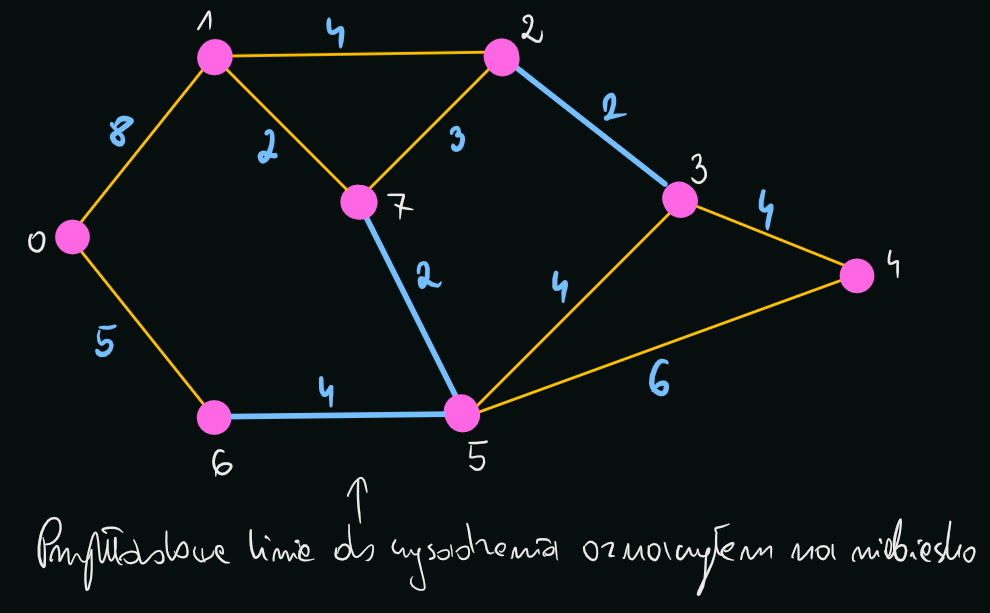

In [68]:
E = [(0, 1, 8), (0, 6, 5), (1, 2, 4), (1, 7, 2), (7, 2, 3), (6, 5, 4), (7, 5, 2), (2, 3, 2), 
     (5, 3, 4), (5, 4, 6), (3, 4, 4)]

A = 0
B = 4
blow_up_lines(E, A, B)

(8, [(7, 5), (2, 3), (6, 5)])

In [69]:
A = 7
B = 4
blow_up_lines(E, A, B)

(7, [(7, 1), (7, 2), (7, 5)])

In [70]:
A = 3
B = 4
blow_up_lines(E, A, B)

(10, [(3, 2), (3, 5), (3, 4)])

In [71]:
A = 5
B = 4
blow_up_lines(E, A, B)

(10, [(3, 4), (5, 4)])

##### Dla grafu skierowanego (działa prawidłowo, otrzymujemy te same rezultaty, co w Implementacji #1):

Musimy nadpisać końcową funkcję, aby tworzyła graf skierowany.

In [72]:
def blow_up_lines(L: 'lines array', s: 'begin city', t: 'end city'):
    G = directed_weighted_graph_list(L)
    n = len(G)
    cost, RG = edmonds_karp(G, s, t)
    # Find lines to remove
    lines = find_lines_to_remove(G, RG, s, n)
    return cost, lines

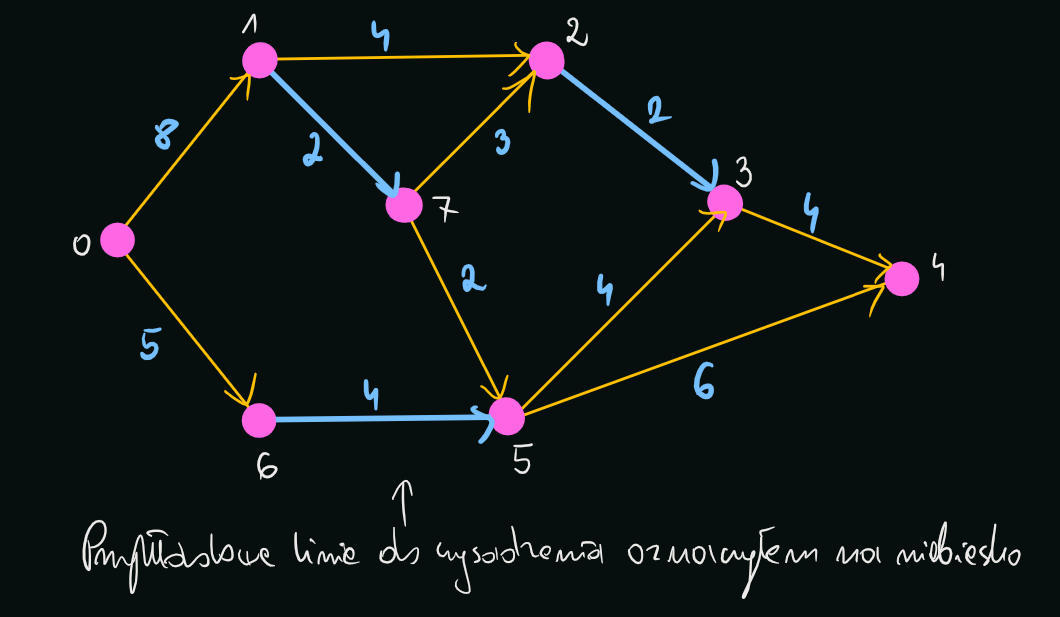

In [73]:
E = [(0, 1, 8), (0, 6, 5), (1, 2, 4), (1, 7, 2), (7, 2, 3), (6, 5, 4), (7, 5, 2), (2, 3, 2), 
     (5, 3, 4), (5, 4, 6), (3, 4, 4)]
A = 0
B = 4

print(blow_up_lines(E, A, B))

(8, [(2, 3), (1, 7), (6, 5)])


In [74]:
# Teraz przykład dla nieco innych miast
A = 7
B = 4

print(blow_up_lines(E, A, B))

(4, [(2, 3), (7, 5)])


In [76]:
# Teraz przykład, który nie ma rozwiązania (zły kierunek)
A = 5
B = 6

print(blow_up_lines(E, A, B))

(0, [])
